In [ ]:
# @title Imports (run this cell)
from __future__ import print_function

import typing
from typing import Union, List, Optional
import numpy as np
import pandas as pd
import collections
from numpy import linalg as LA
from mpl_toolkits.mplot3d import Axes3D
from IPython import display
from matplotlib import pyplot as plt
import sklearn
import sklearn.manifold
import tensorflow.compat.v1 as tf

import ipywidgets as widgets
from IPython.display import display
import warnings
warnings.filterwarnings('ignore')

tf.disable_v2_behavior()
tf.logging.set_verbosity(tf.logging.ERROR)

# Add some convenience functions to Pandas DataFrame.
pd.options.display.max_rows = 10
pd.options.display.float_format = '{:.3f}'.format
def mask(df, key, function):
  """Returns a filtered dataframe, by applying function to key"""
  return df[function(df[key])]

def flatten_cols(df):
  df.columns = [' '.join(col).strip() for col in df.columns.values]
  return df

pd.DataFrame.mask = mask
pd.DataFrame.flatten_cols = flatten_cols

# Install Altair and activate its colab renderer.
print("Installing Altair...")
!pip install git+git://github.com/altair-viz/altair.git
import altair as alt
alt.data_transformers.enable('default', max_rows=None)
alt.renderers.enable('colab')
print("Done installing Altair.")

# Install spreadsheets and import authentication module.
USER_RATINGS = False
!pip install --upgrade -q gspread
from google.colab import auth
import gspread
from oauth2client.client import GoogleCredentials

Installing Altair...
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning git://github.com/altair-viz/altair.git to /tmp/pip-req-build-wh77y24w
  Running command git clone -q git://github.com/altair-viz/altair.git /tmp/pip-req-build-wh77y24w
  fatal: unable to connect to github.com:
  github.com[0: 140.82.121.4]: errno=Connection timed out

ERROR: Command errored out with exit status 128: git clone -q git://github.com/altair-viz/altair.git /tmp/pip-req-build-wh77y24w Check the logs for full command output.
Done installing Altair.


In [ ]:
# Run it if want to see numerical values from Tensorflow.
#tf.enable_eager_execution()
#tf.executing_eagerly()

True

In [ ]:
def split_dataframe(df, holdout_fraction=0.1):
  """Splits a DataFrame into training and test sets.
  Args:
    df: a dataframe.
    holdout_fraction: fraction of dataframe rows to use in the test set.
  Returns:
    train: dataframe for training
    test: dataframe for testing
  """
  test = df.sample(frac=holdout_fraction, replace=False)
  train = df[~df.index.isin(test.index)]
  return train, test

In [ ]:
# @title Load the LastFM data.

# Download LastFM data.
print("Downloading lastfm data...")
from urllib.request import urlretrieve
import zipfile

urlretrieve("http://files.grouplens.org/datasets/hetrec2011/hetrec2011-lastfm-2k.zip", "lastfm-2k.zip")
zip_ref = zipfile.ZipFile('lastfm-2k.zip', "r")
zip_ref.extractall()
print("Done. Dataset contains:")
for info in zip_ref.infolist():
  print(info)

Done. Dataset contains:
<ZipInfo filename='user_friends.dat' compress_type=deflate external_attr=0x20 file_size=251565 compress_size=74341>
<ZipInfo filename='user_taggedartists.dat' compress_type=deflate external_attr=0x20 file_size=4366696 compress_size=747727>
<ZipInfo filename='user_taggedartists-timestamps.dat' compress_type=deflate external_attr=0x20 file_size=5249917 compress_size=778934>
<ZipInfo filename='artists.dat' compress_type=deflate external_attr=0x20 file_size=1925879 compress_size=453218>
<ZipInfo filename='readme.txt' compress_type=deflate external_attr=0x20 file_size=4627 compress_size=1775>
<ZipInfo filename='tags.dat' compress_type=deflate external_attr=0x20 file_size=234468 compress_size=103433>
<ZipInfo filename='user_artists.dat' compress_type=deflate external_attr=0x20 file_size=1296455 compress_size=428861>


In [ ]:
plays = pd.read_csv('user_artists.dat', sep='\t')
plays = plays.rename(columns = {'weight':'userArtistPlays'})
artists = pd.read_csv('artists.dat', sep='\t')
tags = pd.read_csv('tags.dat', sep='\t', encoding='latin-1')
friends = pd.read_csv('user_friends.dat', sep='\t')
user_tagged_artists = pd.read_csv('user_taggedartists.dat', sep='\t')
user_tagged_artists_time = pd.read_csv('user_taggedartists-timestamps.dat', sep='\t')

In [ ]:
print('User Id stars at: ', plays['userID'].min())
print('Artist Id stars at: ', plays['artistID'].min())
print('User Id finishes at: ', plays['userID'].max())
print('Artist Id finishes at: ', plays['artistID'].max())

User Id stars at:  2
Artist Id stars at:  1
User Id finishes at:  2100
Artist Id finishes at:  18745


Based on the results presented above, you can see that the indexes for artists and users are random numerical values. I decided to create new indexes that will be numeric values ranging from zero to the number of unique users / artists.

In [ ]:
new_artist_id = [i for i in range(artists['id'].nunique())]
artists['new_artist_id'] = new_artist_id
new_artist_plays = []
for value in plays['artistID']:
  new_val = artists[artists['id'] == value]['new_artist_id'].values[0]
  new_artist_plays.append(new_val)
plays['new_artist_id'] = new_artist_plays

In [ ]:
users = pd.DataFrame(plays['userID'].unique())
users['new_id'] = [i for i in range(plays['userID'].nunique())]
new_user_plays = []
for value in plays['userID']:
  new_val = users[users[0] == value]['new_id'].values[0]
  new_user_plays.append(new_val)
plays['new_user_id'] = new_user_plays

The Dataset
1. ***user_artists.dat*** (userId, artistId, weight) - Plays of artist by user. *(plays)* 
2. ***user_frinds.dat*** (userId, friendId) - User friends relationships *(friends)*
3. ***tags.dat*** (tagId, tagValue) Content value for each tag id *(tags)*
4. ***artists.dat*** (id, name, url, pictureURL) Data for each artist *(artists)*
5. ***user_taggedartists-timestamps.dat*** (userId, artistId, tagId, timestamp) Tag of artist by user with timestamp *(user_tagged_artists_time)*
6. ***user_taggedartists.dat*** (userId, artistId, tagId, day, month, year) Tag of artist by user with date *(user_tagged_artists)*

In [ ]:
print('Artists data: ')
print(artists.describe())
print(artists.info())
# duplicates check 
print('No duplicates: {}\n'.format(len(artists) == len(artists.drop_duplicates())))
# No Nan or missing values; No duplicates

Artists data: 
             id
count 17632.000
mean   9156.637
std    5392.515
min       1.000
25%    4501.750
50%    9048.500
75%   13769.250
max   18745.000
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17632 entries, 0 to 17631
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   id          17632 non-null  int64 
 1   name        17632 non-null  object
 2   url         17632 non-null  object
 3   pictureURL  17188 non-null  object
dtypes: int64(1), object(3)
memory usage: 551.1+ KB
None
No duplicates: True



In [ ]:
print('Plays data: ')
print(plays.describe())
print(plays.info())
# duplicates check 
print('No duplicates: {}\n'.format(len(plays) == len(plays.drop_duplicates())))
# No Nan or missing values; No duplicates

Plays data: 
         userID  artistID  userArtistPlays
count 92834.000 92834.000        92834.000
mean   1037.010  3331.123          745.244
std     610.870  4383.591         3751.322
min       2.000     1.000            1.000
25%     502.000   436.000          107.000
50%    1029.000  1246.000          260.000
75%    1568.000  4350.000          614.000
max    2100.000 18745.000       352698.000
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 92834 entries, 0 to 92833
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype
---  ------           --------------  -----
 0   userID           92834 non-null  int64
 1   artistID         92834 non-null  int64
 2   userArtistPlays  92834 non-null  int64
dtypes: int64(3)
memory usage: 2.1 MB
None
No duplicates: True



In [ ]:
print('tags data: ')
print(tags.describe())
print(tags.info())
# duplicates check 
print('No duplicates: {}\n'.format(len(tags) == len(tags.drop_duplicates())))
# No Nan or missing values; No duplicates

tags data: 
          tagID
count 11946.000
mean   6242.315
std    3667.498
min       1.000
25%    3036.250
50%    6210.500
75%    9460.750
max   12648.000
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11946 entries, 0 to 11945
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   tagID     11946 non-null  int64 
 1   tagValue  11946 non-null  object
dtypes: int64(1), object(1)
memory usage: 186.8+ KB
None
No duplicates: True



From the above analysis I can say that in total we have:

*   1892 unique users
*   17632 unique artists
*   11946 unique tags
*   92834 artist/user plays
*   186479 tag assignments

Our Dataset does not contain any duplicates or missing values.


## **EDA**

In [ ]:
# merging and sorting data to get total plays for each artist
artist_plays = pd.merge(artists, plays, how='inner', left_on='id', right_on='artistID')
artist_rank = (artist_plays.groupby('name')).agg({'userID':'count', 'userArtistPlays':'sum'}).rename(columns={'userID':'total_unique_users', 'userArtistPlays':'total_artist_plays'}).sort_values(['total_artist_plays'], ascending=False)
artist_rank['avg_user_plays'] = artist_rank['total_artist_plays'] / artist_rank['total_unique_users']
user_rank = (artist_plays.groupby(['userID']).agg({'name':'count','userArtistPlays':'sum'}).
rename(columns={"name":'totalUniqueArtists',"userArtistPlays":"totalUserPlays"}).
sort_values(['totalUserPlays'],ascending=False))

In [ ]:
artist_plays_artist = artist_plays.join(artist_rank, on='name', how='inner')
artist_plays_user = artist_plays_artist.join(user_rank, on='userID', how='inner').sort_values(['userArtistPlays'], ascending=False)
# Check for duplicated rows
assert len(artist_plays_user[artist_plays_user.duplicated(['userID', 'name'])]) == 0

In [ ]:
# Calculate the total number of plays
print('The total number of plays is:')
print('{:,}'.format(artist_plays_user['userArtistPlays'].sum()))

The total number of plays is:
69,183,975


In [ ]:
# Visualizing Data Insights
import seaborn as sns
import matplotlib.ticker as ticker
def bar_chart_int(x,y,x_label,y_label,title,caption,total_val):
    fig, ax = plt.subplots()
    fig.set_size_inches(16, 5)
    ax = sns.barplot(x[:20], y[:20], palette="PuRd")
    ax.set_xlabel(x_label,fontweight='bold')
    ax.set_ylabel(y_label,fontweight='bold')
    ax.set_title(title,fontweight='bold')
    ax.get_yaxis().set_major_formatter(ticker.FuncFormatter(lambda x, p: '{:,}'.format(int(x))))

    # our bar label placement
    for p in ax.patches:
      height = p.get_height()
      pct = 100*(height/total_val)
      ax.text(p.get_x()+p.get_width()/2., height + 3, '{:1.1f}%'.format(pct),
              ha="center",verticalalignment='bottom',color='black') 

    # our caption statement
    ax.text(19, max(y[:20])*0.95, caption, style='italic',fontsize=12,horizontalalignment='right')

    plt.xticks(rotation=90)
    plt.show()


/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


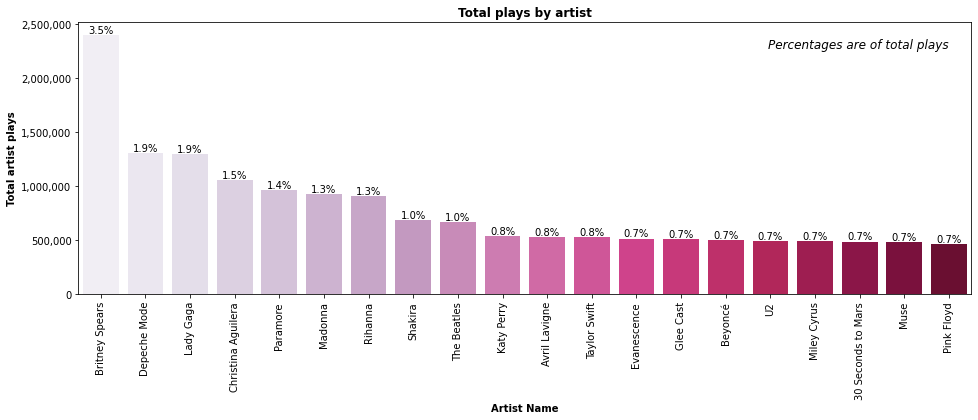

In [ ]:
plot1 = artist_rank
x = plot1.index
y = plot1.total_artist_plays
x_label = 'Artist Name'
y_label = 'Total artist plays'
title = 'Total plays by artist'
caption = 'Percentages are of total plays'
total_val = plot1.total_artist_plays.sum()
bar_chart_int(x, y, x_label, y_label, title, caption, total_val)

The chart above is the top 20 most played artists. You can see the distribution of auditions is quite even, only Britney Spears, who takes the first place, significantly exceeds other artists.

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


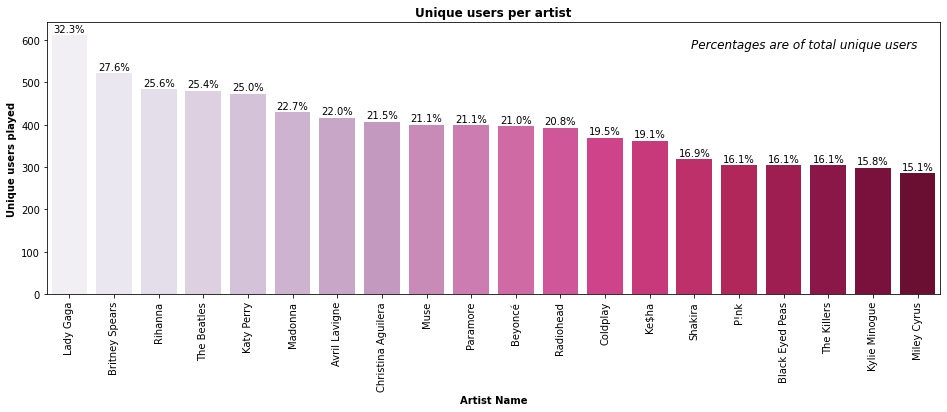

In [ ]:
plot2 = artist_rank.sort_values(['total_unique_users'], ascending=False)
bar_chart_int(x=plot2.index, y=plot2.total_unique_users, x_label='Artist Name', y_label='Unique users played', title='Unique users per artist',
              caption='Percentages are of total unique users', total_val=artist_plays_user.userID.nunique())

In [ ]:
# Some numerical values for the above plot
artist_rank.sort_values(['total_unique_users'], ascending=False).head()
# From the result below it can be seen that
# From the total of 1892 unique users in the dataset 611 of them listened to Lady Gaga at least one time. 
# It is 61100 / 1892 = 32.29 % of all users.

,total_unique_users,total_artist_plays,avg_user_plays
name,,,
Lady Gaga,611,1291387,2113.563
Britney Spears,522,2393140,4584.559
Rihanna,484,905423,1870.709
The Beatles,480,662116,1379.408
Katy Perry,473,532545,1125.888


From the above results we can see that there is a positve correlation between number of artist plays and number of unique users that listened this artist.
I decided t compare total artist plays vs unique users on a single chart.

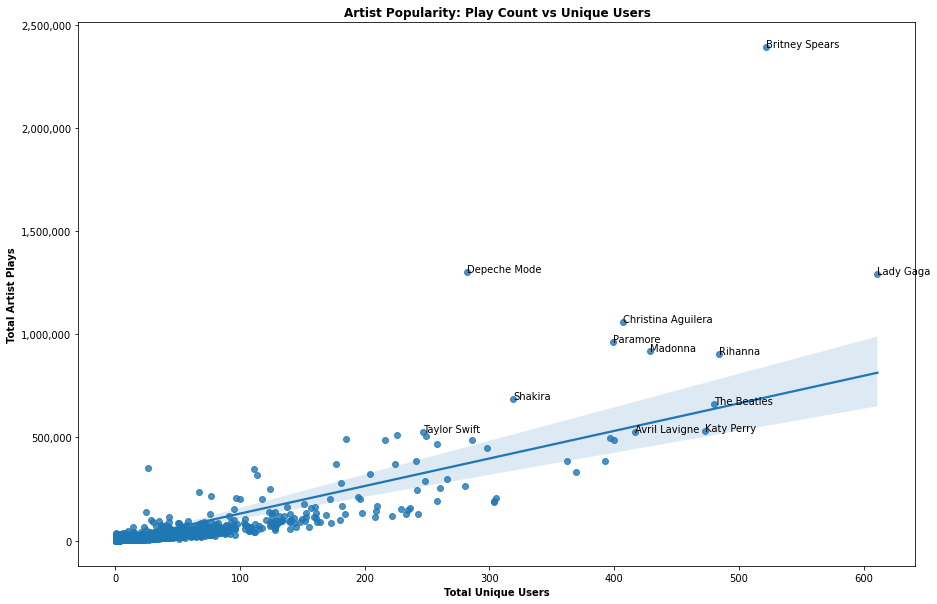

In [ ]:
top_artists = artist_rank.sort_values(['total_artist_plays'],ascending=False).index[:12]

x = artist_rank.total_unique_users
y = artist_rank.total_artist_plays
labels = artist_rank.index

fig, ax = plt.subplots(figsize=(15,10))
sns.regplot(x,y)
ax.set_title('Artist Popularity: Play Count vs Unique Users',fontweight='bold')
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda y, _: '{:,.0f}'.format(y)))
ax.set_xlabel('Total Unique Users',fontweight='bold')
ax.set_ylabel('Total Artist Plays',fontweight='bold')

for i, t in enumerate(labels):
  if t in top_artists:
    ax.annotate(t,(x[i],y[i]))

From the above graph, you can see that basically all the artists, according to the number of listening, are distributed fairly close to each other.

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


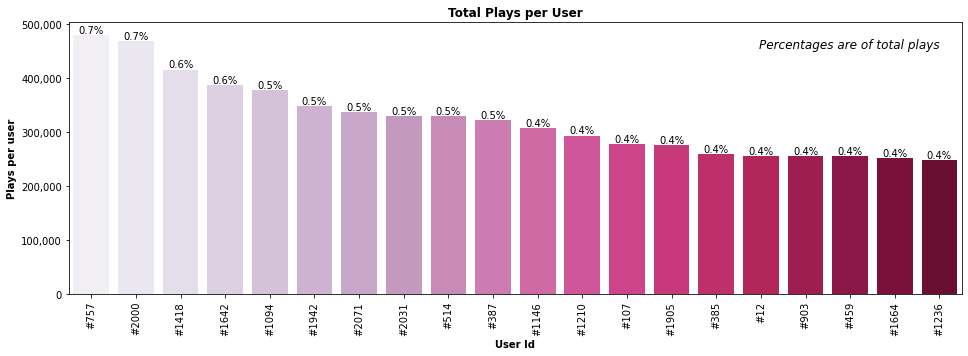

In [ ]:
plot3 = user_rank.sort_values(['totalUserPlays'],ascending=False)
plot3['userID'] = plot3.index
plot3.userID = plot3.userID.apply(lambda x: '#'+str(x))

bar_chart_int(x=plot3.userID,y=plot3.totalUserPlays,x_label='User Id',y_label='Plays per user',title='Total Plays per User',
              caption='Percentages are of total plays', total_val=artist_plays_user.userArtistPlays.sum())

In [ ]:
# @title How loyal are users to the specific artists they listen to. (total artist plays / total unique users)
artist_rank.sort_values(['avg_user_plays'],ascending=False).head()
# From the results below it can be seen that 
# Viking Quest has only one very loyal user that listened to it 35,323 times

,total_unique_users,total_artist_plays,avg_user_plays
name,,,
Viking Quest,1,35323,35323.000
Tyler Adam,1,30614,30614.000
Rytmus,1,23462,23462.000
Johnny Hallyday,2,32995,16497.500
Dicky Dixon,1,15345,15345.000


Analysing Tags 

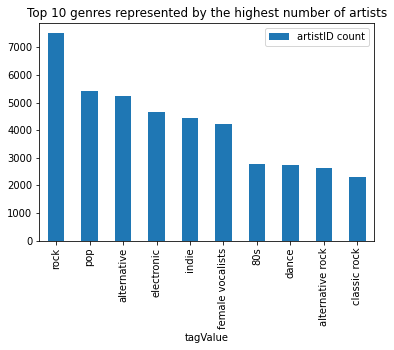

In [ ]:
tags_with_biggest_num_artists = user_tagged_artists.groupby('tagID').agg({'artistID':['count']}).flatten_cols().merge(tags, on='tagID')
# 10 genres with the highest number of artists
x = (tags_with_biggest_num_artists.sort_values('artistID count', ascending=False)
 .head(10))
x.plot.bar(y='artistID count', x ='tagValue', title='Top 10 genres represented by the highest number of artists',rot=90)
# Genre that has the most unique artists taged is Rock

From the graph above, you can see the top 10 popular tags. From the above graph, we can conclude that tags are not only musical genres, but can be absolutely any value. We can see that for example rock has subcategories such as (rock, classic rock, alternative rock)
We also can see the numerical value (80s), and tags that are difficult to associate with any particular musical genre such as dance and female vocalists.
Thus, the tag data is very dirty and I don't want to build my recommendation system based on it.

# **Recommender System**
After completing my EDA I decided that I would not use clustering because my data is high dimensional and has a lot of data items. Using **Clustering** might NOT be good of the **time complexity.** Moreover, due to the fact that all data items are located close enough to each other, it might be hard to cluster this kind of data.

At the core of my recommendation system, I decided to use plays dataset that includes user, artist and plays counts data.
I decided to use User-Based Collaborative Filtering to predict the items that a user might like on the basis of plays given to that item by the other users who have similar taste with that of the target user.
Since I was able to detect a correlation between the number of plays and the popularity of an artist, I can conclude that the top recommendations will always be the most popular artists.


In [ ]:
# @title Building a Sparce Matrix
def build_plays_sparse_tensor(cutted_plays: pd.DataFrame):
  """
  Args:
    plays: a pd.DataFrame that contains `new_user_id`, `new_artist_id' and `userArtistPlays` columns.
  Returns:
    a tf.SparseTensor representing the ratings matrix.
  """
  indices = cutted_plays[['new_user_id', 'new_artist_id']].values
  values = cutted_plays['userArtistPlays'].values
  tensor = tf.SparseTensor(
    indices=indices,
    values=values,
    dense_shape=[plays['userID'].nunique(), artists['id'].nunique()])
  return tensor

In [ ]:
# @title Calculating the Error
def sparse_mean_square_error(sparse_plays, user_embeddings, artist_embeddings):
  """
  Args:
    sparse_plays: A SparseTensor plays matrix, of dense_shape [N, M]
    user_embeddings: A dense Tensor U of shape [N, k] where k is the embedding
      dimension, such that U_i is the embedding of user i.
    artist_embeddings: A dense Tensor V of shape [M, k] where k is the embedding
      dimension, such that V_j is the embedding of movie j.
  Returns:
    A scalar Tensor representing the MSE between the true ratings and the
      model's predictions.
  """
  predictions = tf.gather_nd(
      tf.matmul(user_embeddings, artist_embeddings, transpose_b=True), sparse_plays.indices)
  loss = tf.losses.mean_squared_error(sparse_plays.values, predictions)
  return loss

# Training a Matrix Factorization model

In [ ]:
# @title CFModel helper class
class CFModel(object):
  """Simple class that represents a collaborative filtering model"""
  def __init__(self, embedding_vars, loss, metrics=None):
    """Initializes a CFModel.
    Args:
      embedding_vars: A dictionary of tf.Variables.
      loss: A float Tensor. The loss to optimize.
      metrics: optional list of dictionaries of Tensors. The metrics in each
        dictionary will be plotted in a separate figure during training.
    """
    self._embedding_vars = embedding_vars
    self._loss = loss
    self._metrics = metrics
    self._embeddings = {k: None for k in embedding_vars}
    self._session = None

  @property
  def embeddings(self):
    """The embeddings dictionary."""
    return self._embeddings

  def train(self, num_iterations=100, learning_rate=1.0, plot_results = bool,
            optimizer=tf.train.GradientDescentOptimizer):
    """Trains the model.
    Args:
      iterations: number of iterations to run.
      learning_rate: optimizer learning rate.
      plot_results: whether to plot the results at the end of training.
      optimizer: the optimizer to use. Default to GradientDescentOptimizer.
    Returns:
      The metrics dictionary evaluated at the last iteration.
    """
    with self._loss.graph.as_default():
      opt = optimizer(learning_rate)
      train_op = opt.minimize(self._loss)
      local_init_op = tf.group(
          tf.variables_initializer(opt.variables()),
          tf.local_variables_initializer())
      if self._session is None:
        self._session = tf.Session()
        with self._session.as_default():
          self._session.run(tf.global_variables_initializer())
          self._session.run(tf.tables_initializer())
          tf.train.start_queue_runners()

    with self._session.as_default():
      local_init_op.run()
      iterations = []
      metrics = self._metrics or ({},)
      metrics_vals = [collections.defaultdict(list) for _ in self._metrics]

      # Train and append results.
      for i in range(num_iterations + 1):
        _, results = self._session.run((train_op, metrics))
        if (i % 10 == 0) or i == num_iterations:
          print("\r iteration %d: " % i + ", ".join(
                ["%s=%f" % (k, v) for r in results for k, v in r.items()]),
                end='')
          iterations.append(i)
          for metric_val, result in zip(metrics_vals, results):
            for k, v in result.items():
              metric_val[k].append(v)

      for k, v in self._embedding_vars.items():
        self._embeddings[k] = v.eval()

      if plot_results:
        # Plot the metrics.
        num_subplots = len(metrics)+1
        fig = plt.figure()
        fig.set_size_inches(num_subplots*10, 8)
        for i, metric_vals in enumerate(metrics_vals):
          ax = fig.add_subplot(1, num_subplots, i+1)
          for k, v in metric_vals.items():
            ax.plot(iterations, v, label=k)
          ax.set_xlim([1, num_iterations])
          ax.legend()
      return results

In [ ]:
def build_model(plays:pd.DataFrame, embedding_dim=3, init_stddev=1.):
  """
  Args:
    plays: a DataFrame of the plays
    embedding_dim: the dimension of the embedding vectors.
    init_stddev: float, the standard deviation of the random initial embeddings.
  Returns:
    model: a CFModel.
  """
  # Split the plays DataFrame into train and test.
  train_plays, test_plays = split_dataframe(plays)
  # SparseTensor representation of the train and test datasets.
  A_train = build_plays_sparse_tensor(train_plays)
  A_test = build_plays_sparse_tensor(test_plays)
  # Initialize the embeddings using a normal distribution.
  U = tf.Variable(tf.random_normal(
      [A_train.dense_shape[0], embedding_dim], stddev=init_stddev))
  V = tf.Variable(tf.random_normal(
      [A_train.dense_shape[1], embedding_dim], stddev=init_stddev))
  train_loss = sparse_mean_square_error(A_train, U, V)
  test_loss = sparse_mean_square_error(A_test, U, V)
  metrics = {
      'train_error': train_loss,
      'test_error': test_loss
  }
  embeddings = {
      "new_user_id": U,
      "new_artist_id": V
  }
  
  return CFModel(embeddings, train_loss, [metrics])

In [ ]:
# Extracting dataset column that the Recommender system is gonna train on
cutted_plays = plays[['new_artist_id', 'new_user_id', 'userArtistPlays']]

 iteration 150: train_error=107428.656250, test_error=7539484.000000

[{'train_error': 107428.66, 'test_error': 7539484.0}]

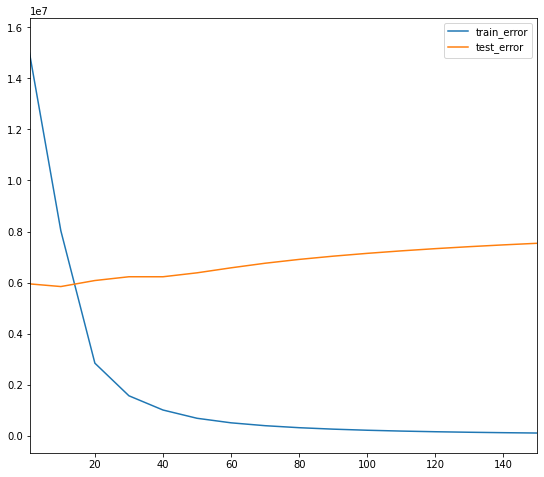

In [ ]:
# Build the CF model and train it.
model = build_model(cutted_plays, embedding_dim=30, init_stddev=1)
model.train(num_iterations=150, learning_rate=0.09, plot_results = True)

# **Inspecting the Embeddings**

In [ ]:
DOT = 'dot'
COSINE = 'cosine'
def compute_scores(query_embedding, item_embeddings, measure=DOT):
  """Computes the scores of the candidates given a query.
  Args:
    query_embedding: a vector of shape [k], representing the query embedding.
    item_embeddings: a matrix of shape [N, k], such that row i is the embedding
      of item i.
    measure: a string specifying the similarity measure to be used. Can be
      either DOT or COSINE.
  Returns:
    scores: a vector of shape [N], such that scores[i] is the score of item i.
  """
  u = query_embedding
  V = item_embeddings
  if measure == COSINE:
    V = V / np.linalg.norm(V, axis=1, keepdims=True)
    u = u / np.linalg.norm(u)
  scores = u.dot(V.T)
  return scores

I decided to create another dataset that will include the top 5 tags for each artist. It is going to be a summary textual representation of each artist. Using such a combination of tags, I plan to evaluate the quality of my recommendations.

In [ ]:
tags_combined = []
for id in artists['id']:
  top_5_per_artist = list(user_tagged_artists[user_tagged_artists['artistID'] == id]['tagID'].value_counts(ascending=False).index[:5])
  tags_combined.append(' '.join([str(elem) for elem in top_5_per_artist]))
artists['tags_combined'] = tags_combined

new_name_col = []
missing_artist_ids = []
new_id_col = []
all_artist_ids = set(artists['id'])
for id in user_tagged_artists['artistID']:
  if id in all_artist_ids:
    new_val = artists[artists['id'] == id]['name'].values[0]
    new_name_col.append(new_val)
    new_id = artists[artists['id'] == id]['new_artist_id'].values[0]
    new_id_col.append(new_id)
  else:
    missing_artist_ids.append(id)
    new_name_col.append(np.NaN)
    new_id_col.append(np.NaN)
artist_vs_tags = pd.DataFrame()
artist_vs_tags['artistID'] = user_tagged_artists['artistID']
artist_vs_tags['artist_name'] = new_name_col
artist_vs_tags['new_artist_id'] = new_id_col
# dropping rows that have missing values
artist_vs_tags = artist_vs_tags[artist_vs_tags['artist_name'].notna()]
artist_vs_tags['new_artist_id'] = artist_vs_tags['new_artist_id'].astype(int)
artist_vs_tags['new_artist_id'].nunique()

12133

When I was processing tags I found out that there are more artist ids that are not listed in artists or plays dataframe. For example artist with id 14. I will just create a list where I will be storing these missing artist ids

In [ ]:
user_tagged_artists[user_tagged_artists['artistID']==14]

,userID,artistID,tagID,day,month,year
3267,40,14,61,1,9,2008
3268,40,14,86,1,9,2008
55420,557,14,10,1,10,2009
55421,557,14,12,1,10,2009
55422,557,14,565,1,10,2009


In [ ]:
plays[plays['artistID']==14]

,userID,artistID,userArtistPlays,new_artist_id,new_user_id


In [ ]:
artists[artists['id']==14]

,id,name,url,pictureURL,new_artist_id


I came across the following problem. Orginal plays and artists datasets contain 17632 unique artists. When user_tagged_artists contains only 12133 unique artists that are listed in plays dataset. 
Since not all artists were tagged by users I decided to make a new dataset that I will be able to process in future. 

In [ ]:
# Reducing cutted_plays datset so that it cotains only artists that were tagged by users
# I will be doing following by new_artist_id
unique_ids_tags = set(artist_vs_tags['new_artist_id'])
fixed_plays = cutted_plays.loc[cutted_plays['new_artist_id'].isin(unique_ids_tags)]

In [ ]:
# @title User recommendations and nearest neighbors
def user_recommendations(model, measure=DOT, exclude_rated=False, k=6):
  if USER_RATINGS:
    scores = compute_scores(
        model.embeddings["new_user_id"][1892], model.embeddings["new_artist_id"], measure)
    score_key = measure + ' score'
    df = pd.DataFrame({
        score_key: list(scores),
        'artist_id': artist_vs_tags['new_artist_id'],
        'names': artist_vs_tags['artist_name'],
        'genres': artist_vs_tags['tagID'],
    })
    if exclude_rated:
      # remove artists that are already tagged
      tagged_artists = plays[plays.userID == "1893"]["artistID"].values
      df = df[df.artist_id.apply(lambda artist_id: artist_id not in tagged_artists)]
    display(df.sort_values([score_key], ascending=False).head(k))
    return df.sort_values([score_key], ascending=False)

def artist_neighbors(model, title_substring, measure=DOT, k=6):
  # Search for movie ids that match the given substring.
  ids =  artist_vs_tags[artist_vs_tags['artist_name'].str.contains(title_substring)]['new_artist_id'].values
  names = artist_vs_tags.loc[artist_vs_tags['new_artist_id'].isin(ids)]['artist_name'].values
  if len(names) == 0:
    raise ValueError("Found no movies with title %s" % title_substring)
  print("Nearest neighbors of : %s." % names[0])
  if len(names) > 1:
    print("[Found more than one matching artist. Other candidates: {}]".format(
        ", ".join(names[1:])))
  artist_id = ids[0]
  scores = compute_scores(
      model.embeddings["new_artist_id"][artist_id], model.embeddings["new_artist_id"],
      measure)
  score_key = measure + ' score'
  df = pd.DataFrame({
      score_key: list(scores),
      'titles': artist_vs_tags['artist_name'],
      'genres': artist_vs_tags['tagID']
  })
  display(df.sort_values([score_key], ascending=False).head(k))
  #  Want also to return df, so I could process Tags for each returned artist
  return df

In [ ]:
# Now when I have fixed_plays some of indicies are gonna be out of range
fixed_plays_ind_fix = fixed_plays.copy()

a = pd.DataFrame(fixed_plays['new_artist_id'].unique())
a['new_id'] = [i for i in range(fixed_plays['new_artist_id'].nunique())]
x = []
for value in fixed_plays_ind_fix['new_artist_id']:
  new_val = a[a[0] == value]['new_id'].values[0]
  x.append(new_val)
fixed_plays_ind_fix.rename(columns={'new_artist_id':'old_artist_id'}, inplace=True)
fixed_plays_ind_fix['new_artist_id'] = x
fixed_plays_ind_fix['new_artist_id'].nunique()


12133

In [ ]:
from six.moves import UserList
def build_plays_sparse_tensor(cutted_plays):
  indices = cutted_plays[['new_user_id', 'new_artist_id']].values
  values = cutted_plays['userArtistPlays'].values
  tensor = tf.SparseTensor(
    indices=indices,
    values=values,
    dense_shape=[users['new_id'].nunique(), fixed_plays_ind_fix['new_artist_id'].nunique()])
  return tensor

 iteration 150: train_error=96040.414062, test_error=20070016.000000

[{'train_error': 96040.414, 'test_error': 20070016.0}]

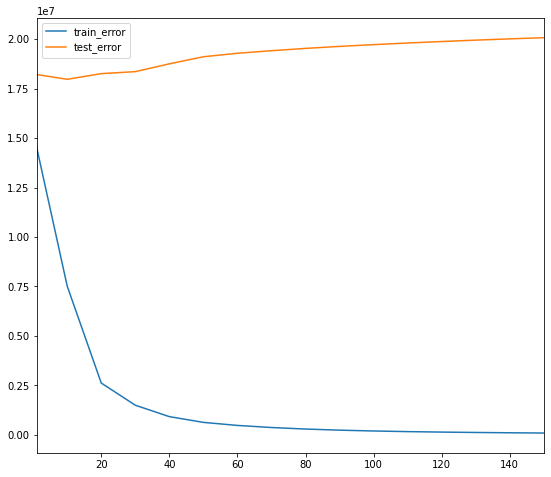

In [ ]:
model_1 = build_model(fixed_plays_ind_fix, embedding_dim=30, init_stddev=1)
model_1.train(num_iterations=150, learning_rate=0.09, plot_results = True)

Above is **Figure 1**. As I reduced the dataset for training my test error increased and I can see that my model overfits.

In [ ]:
# Preparing dataset that has tag information for each artist
new_tags_col = []
for id in artist_vs_tags['artistID']:
  new_val = artists[artists['id'] == id]['tags_combined'].values[0]
  new_tags_col.append(new_val)
artist_vs_tags['tagID'] = new_tags_col
# Now changing index again for artist_vs_tags
l = []
for old_ind in artist_vs_tags['new_artist_id']:
  new_val = fixed_plays_ind_fix[fixed_plays_ind_fix['old_artist_id'] == old_ind]['new_artist_id'].values[0]
  l.append(new_val)
artist_vs_tags.rename(columns={'new_artist_id':'old_artist_id'}, inplace=True)
artist_vs_tags['new_artist_id'] = l
artist_vs_tags = artist_vs_tags.drop_duplicates()

In [ ]:
# Finding the closest artists for Lady Gaga
artist_neighbors(model_1, "Lady Gaga", DOT)
artist_neighbors(model_1, "Lady Gaga", COSINE)
# From the below output wanna look more deeply into genres

Nearest neighbors of : Lady Gaga.


,dot score,titles,genres
122,122704.516,Stereophonics,73 79 81 389 84
4459,46498.527,Switchfoot,73 78 183 1252 79
3489,40010.598,Justice,18 39 309 187 321
23349,39570.398,WC,181 102 103 197
209,33144.531,Flagelo Urbano,100 101 112 113 114
3660,32956.172,Das Pop,24 614 9829


Nearest neighbors of : Lady Gaga.


,cosine score,titles,genres
122,1.000,Stereophonics,73 79 81 389 84
23349,0.917,WC,181 102 103 197
126933,0.892,今井翼,24 200 234 238 306
22071,0.887,Sybreed,6 385 619 1 1359
4459,0.868,Switchfoot,73 78 183 1252 79
8167,0.860,Stephanie Mills,130 508 625


,cosine score,titles,genres
0,-0.024,Morcheeba,21 13 15 18 130
5,0.004,Enigma,23 14 13 18 1495
9,-0.092,Café Del Mar,13 15 20 14 38
17,0.021,Ministry of Sound,13 15 20 21 22
25,0.047,Fleetwood Mac,192 735 73 829 25
...,...,...,...
186456,0.235,Controller 7,758
186457,-0.239,padmo',15 758
186459,0.102,Electrosoul System,626 2485
186465,0.093,Andrius Mamontovas,3271


In [ ]:
# genres for Lady Gaga
artist_vs_tags[artist_vs_tags['artist_name']=='Lady Gaga']['tagID']

395    24 39 18 130 658
Name: tagID, dtype: object

Since I am not familiar with most of these artists, measuring the accuracy of my model will be quite difficult. At the moment, I want to try to evaluate the similarity of artists by the similarity of the top tags made by users. At the they are represented by their ids and have no meaning. In the future, with the help of NLP, I want to measure the similarity between tags and improve my model so it returns to the user artists with the most similar tags.

In [ ]:
# @title Embedding Visualization code
genre_filter = alt.selection_multi(fields=['genre'])
genre_chart = alt.Chart().mark_bar().encode(
    x="count()",
    y=alt.Y('genre'),
    color=alt.condition(
        genre_filter,
        alt.Color("genre:N"),
        alt.value('lightgray'))
).properties(height=300, selection=genre_filter)

def artist_embedding_norm(models):
  """Visualizes the norm and number of ratings of the movie embeddings.
  Args:
    model: A MFModel object.
  """
  if not isinstance(models, list):
    models = [models]
  df = pd.DataFrame({
      'name': artist_vs_tags['artist_name'],
      'genre': artist_vs_tags['tagID'],
  })
  # getting the sum of plays for each artist
  new = pd.DataFrame(fixed_plays_ind_fix.groupby('new_artist_id')['userArtistPlays'].sum())
  plays_sum = []
  for id in artist_vs_tags['new_artist_id']:
    plays_sum.append(new[new.index == id]['userArtistPlays'].values)
  df['total_plays'] = plays_sum

  charts = []
  brush = alt.selection_interval()
  for i, model in enumerate(models):
    norm_key = 'norm'+str(i)
    df[norm_key] = np.linalg.norm(model.embeddings["new_artist_id"], axis=1)
    nearest = alt.selection(
        type='single', encodings=['x', 'y'], on='mouseover', nearest=True,
        empty='none')
    base = alt.Chart().mark_circle().encode(
        x='total_plays',
        y=norm_key,
        color=alt.condition(brush, alt.value('#4c78a8'), alt.value('lightgray'))
    ).properties(
        selection=nearest).add_selection(brush)
    text = alt.Chart().mark_text(align='center', dx=5, dy=-5).encode(
        x='total_plays', y=norm_key,
        text=alt.condition(nearest, 'name', alt.value('')))
    charts.append(alt.layer(base, text))
  return alt.hconcat(*charts, data=df)

def visualize_artist_embeddings(data, x, y):
  nearest = alt.selection(
      type='single', encodings=['x', 'y'], on='mouseover', nearest=True,
      empty='none')
  base = alt.Chart().mark_circle().encode(
      x=x,
      y=y,
      color=alt.condition(genre_filter, "genre", alt.value("whitesmoke")),
  ).properties(
      width=600,
      height=600,
      selection=nearest)
  text = alt.Chart().mark_text(align='left', dx=5, dy=-5).encode(
      x=x,
      y=y,
      text=alt.condition(nearest, 'name', alt.value('')))
  return alt.hconcat(alt.layer(base, text), genre_chart, data=data)

def tsne_artist_embeddings(model):
  """Visualizes the movie embeddings, projected using t-SNE with Cosine measure.
  Args:
    model: A MFModel object.
  """
  tsne = sklearn.manifold.TSNE(
      n_components=2, perplexity=40, metric='cosine', early_exaggeration=10.0,
      init='pca', verbose=True, n_iter=400)

  print('Running t-SNE...')
  V_proj = tsne.fit_transform(model.embeddings["new_artist_id"])
  artist_vs_tags.loc[:,'x'] = V_proj[:, 0]
  artist_vs_tags.loc[:,'y'] = V_proj[:, 1]
  return visualize_artist_embeddings(artist_vs_tags, 'x', 'y')

In [ ]:
artist_embedding_norm(model_1)

alt.HConcatChart(...)

* x axis represnts the number of plays
* Since the total number of plays per artist can be any number in range (inf;inf)
* The below plot looks like this
* It can also be seen that there are a lot of artists with the number f plays less than 10
* There are also a couple of outliers with the highest number of plays

## Regularization In Matrix Factorization




In [ ]:
# Trying regularization in matrix factorization to improve model performance
def gravity(U, V):
  """Creates a gravity loss given two embedding matrices."""
  return 1. / (U.shape[0].value*V.shape[0].value) * tf.reduce_sum(
      tf.matmul(U, U, transpose_a=True) * tf.matmul(V, V, transpose_a=True))

def build_regularized_model(
    fixed_plays_ind_fix, embedding_dim=3, regularization_coeff=.1, gravity_coeff=1.,
    init_stddev=0.1):
  """
  Args:
    ratings: the DataFrame of movie ratings.
    embedding_dim: The dimension of the embedding space.
    regularization_coeff: The regularization coefficient lambda.
    gravity_coeff: The gravity regularization coefficient lambda_g.
  Returns:
    A CFModel object that uses a regularized loss.
  """
  # Split the ratings DataFrame into train and test.
  train_ratings, test_ratings = split_dataframe(fixed_plays_ind_fix)
  # SparseTensor representation of the train and test datasets.
  A_train = build_plays_sparse_tensor(train_ratings)
  A_test = build_plays_sparse_tensor(test_ratings)
  U = tf.Variable(tf.random_normal(
      [A_train.dense_shape[0], embedding_dim], stddev=init_stddev))
  V = tf.Variable(tf.random_normal(
      [A_train.dense_shape[1], embedding_dim], stddev=init_stddev))

  error_train = sparse_mean_square_error(A_train, U, V)
  error_test = sparse_mean_square_error(A_test, U, V)
  gravity_loss = gravity_coeff * gravity(U, V)
  regularization_loss = regularization_coeff * (
      tf.reduce_sum(U*U)/U.shape[0].value + tf.reduce_sum(V*V)/V.shape[0].value)
  total_loss = error_train + regularization_loss + gravity_loss
  losses = {
      'train_error_observed': error_train,
      'test_error_observed': error_test,
  }
  loss_components = {
      'observed_loss': error_train,
      'regularization_loss': regularization_loss,
      'gravity_loss': gravity_loss,
  }
  embeddings = {"new_user_id": U, "new_artist_id": V}

  return CFModel(embeddings, total_loss, [losses, loss_components])

 iteration 100: train_error_observed=468456.875000, test_error_observed=15950196.000000, observed_loss=468456.875000, regularization_loss=494.206268, gravity_loss=197018.140625

[{'train_error_observed': 468456.88, 'test_error_observed': 15950196.0},
 {'observed_loss': 468456.88,
  'regularization_loss': 494.20627,
  'gravity_loss': 197018.14}]

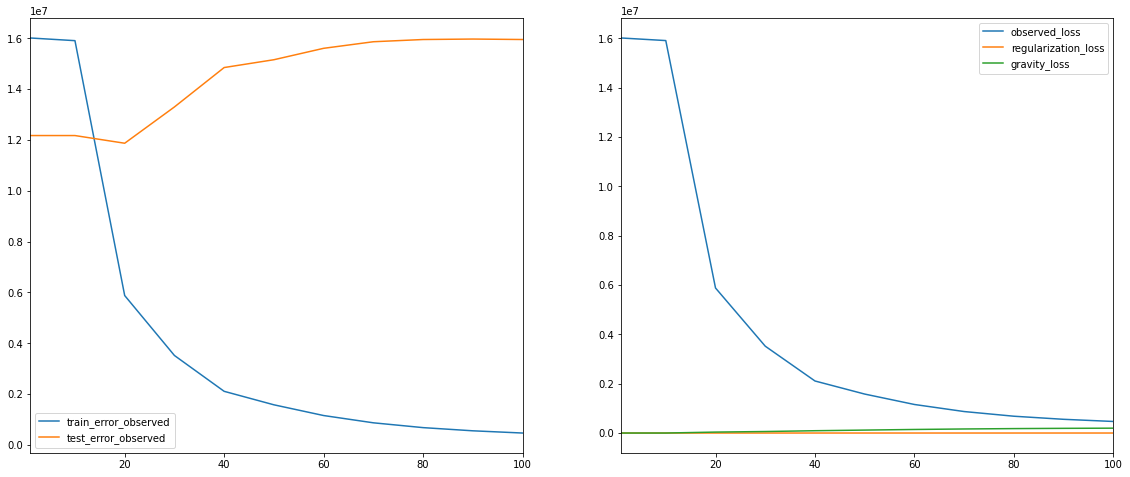

In [ ]:
reg_model = build_regularized_model(
    fixed_plays_ind_fix, regularization_coeff=0.1, gravity_coeff=1.0, embedding_dim=35,
    init_stddev=.05)
reg_model.train(num_iterations=100, learning_rate=0.08)

After regularization in matrix factorization, I compared the training graphs of the models. The first one without and after regularization. The first graph can be found in **Figure 1.** Having studied both graphs, I can conclude that after regularization, my model began to overfit less and the test error decreased. On the first graph with original model, it can be seen that test error fluctuates approximately in the range [1.7; 1.9], and on this it is in range [1.2; 1.6].
In my further research I will be using model after regularization in matrix factorization.

# Representing Tags by Word Embeddings

Since I am not familiar with all the artists that are presented in the recommendation, I do not have the opportunity to evaluate the results of my model qualitatively.
In the next section, I decided to improve the results of my recommender system so that the actors offered to the user are also sorted by thier tag similarity.
To do this, I decided to use NLP tools to measure the similarity of tags.
By my logic similar artists should have tags that have small similarity distance in the vector space.

In [ ]:
#pip install --upgrate gensim

In [ ]:
warnings.filterwarnings(action='ignore',module='gensim')
from gensim.models import Word2Vec
import nltk
from nltk.corpus import stopwords, wordnet
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('omw-1.4')
nltk.download('words')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Package words is already up-to-date!


True

Since during the preparation of genre ids I extracted only the top 5 most common genres  for each actor, I can remove unpopular tags that either do not make sense or are from a different language or with incorrect spelling and others.

In [ ]:
# @title Removing stop words from tags and meaningless tags
all_genres = list(tags['tagValue'])
all_genres_str = (' ').join(all_genres)
all_genres = set(all_genres_str.split(' '))
# since some of the tag values represent stop words I would love to remove them
stop_words = set(stopwords.words('english'))
all_genres_cleaned_1 = [w for w in all_genres if not w.lower() in stop_words]
words = set(nltk.corpus.words.words())
meaningless_words = []
for w in all_genres_cleaned_1:
  if len(w.split(' ')) == 1:
    if w not in words:
      meaningless_words.append(w)
meaningless_words[30:45] # example of meaningless words
all_genres_cleaned = [w for w in all_genres_cleaned_1 if not w in meaningless_words]
print('in total I have removed', len(set(all_genres)) - len(set(all_genres_cleaned)), 'tags')
print('final list of tags has', len(all_genres_cleaned), 'unique tags')

in total I have removed 6312 tags
final list of tags has 3298 unique tags


## **Visual Representation of Tags in a vector Space**

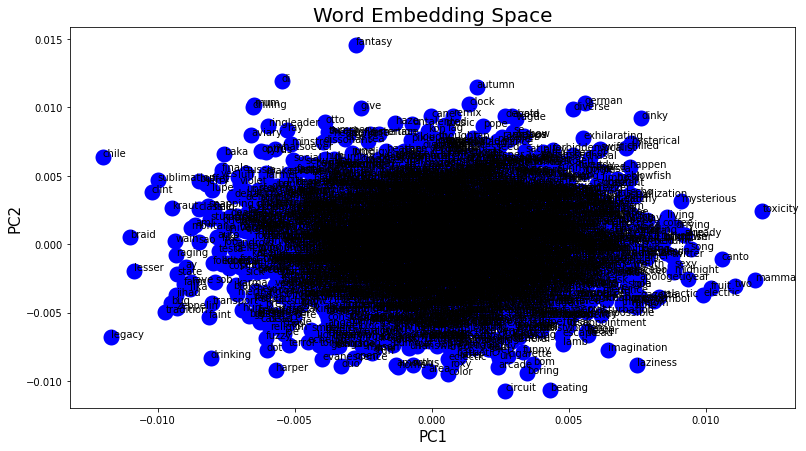

In [ ]:
# Tokenization of tags
token = [nltk.word_tokenize(words) for words in all_genres_cleaned]
model_emb = Word2Vec(token,size=100,sg=0,min_count=1, window=500)
words=list(model_emb.wv.vocab)
X=model_emb[model_emb.wv.vocab]
df=pd.DataFrame(X)
df.shape
df.head()
#Computing the correlation matrix
X_corr=df.corr()
#Computing eigen values and eigen vectors
values,vectors=np.linalg.eig(X_corr)
#Sorting the eigen vectors coresponding to eigen values in descending order
args = (-values).argsort()
values = vectors[args]
vectors = vectors[:, args]
#Taking first 2 components which explain maximum variance for projecting
new_vectors=vectors[:,:2]
#Projecting it onto new dimesion with 2 axis
neww_X=np.dot(X,new_vectors)
plt.figure(figsize=(13,7))
plt.scatter(neww_X[:,0],neww_X[:,1],linewidths=10,color='blue')
plt.xlabel("PC1",size=15)
plt.ylabel("PC2",size=15)
plt.title("Word Embedding Space",size=20)
vocab=list(model_emb.wv.vocab)
for i, word in enumerate(vocab):
  plt.annotate(word,xy=(neww_X[i,0],neww_X[i,1]))

From the above graph, you can see that all the tags are quite close to each other. This is a very overloaded chart as it represents more than 6,000 unique words.

In [ ]:
# @title Tags Embedding Function
def tags_embedding_model(
    tokens: List, 
    window: Optional[int]=None, 
    size: Optional[int]=None,
    sg: Optional[int]=None):
  token = [nltk.word_tokenize(words) for words in all_genres_cleaned]
  model_emb = Word2Vec(token,size=100,sg=0,min_count=1, window=500)
  return model_emb
# example of use
print('Similarity beetwen pop and dance is', tags_embedding_model(token).similarity('pop', 'dance'))

Similarity beetwen pop and dance is -0.22903718


In [ ]:
# @title Run this cell
# I will be calculating the average of tags similarity for each pair of artists
# Finding the closest by semantic tags to the query artist 
def getting_best_artists_on_tag_similarity(model_1,
                                           artist_name : str, 
                                           score : str,
                                           relevance:Optional[int]=None ):
  '''
  This function takes already existing model and uses its recommendations to find the most relevant to the user based on the similarity between
  Args
  -----------
  score : str [COSINE, DOT]
  relevance: better to use 0, 1 or 2 (how many similar tags should an artist have)
  Returns
  -----------
  List of similar artists that user might be interested
  '''
  # Training the model 
  # model_1 = build_model(fixed_plays_ind_fix, embedding_dim=30, init_stddev=1)
  # model_1.train(num_iterations=150, learning_rate=0.09, plot_results = False)
  if relevance == None:
    relevance = 0
  # Now the key idea becomes to find artists with the most similar tags from top 10 returned by existing RS
  print('\n First of all, your recommendation is based on the similarity of each artist in terms of the interests of other users,')
  print('moreover it is also taking into account the number of plays for each artist.')
  print('Your top 5 recommendations based on', score, 'score')
  result_df = artist_neighbors(model_1, artist_name, score)
  if score == COSINE:
    result_df['cosine score'].sort_values(ascending=False)
    top_10 = result_df.sort_values('cosine score', ascending=False)[:10]
  else:
    result_df['dot score'].sort_values(ascending=False)
    top_10 = result_df.sort_values('dot score', ascending=False)[:10]
  print('More specialized recommendations for your chosen artist')
  all_genres = list(top_10['genres'])
  all = []
  for s in all_genres:
    genres_unique = s.split()
    for i in genres_unique:
      all.append(i)
  # processing each tag vs each tag in querry artist
  query_tags = artist_vs_tags[artist_vs_tags['artist_name']==artist_name]['tagID'].values
  # Finding original tag name
  all_results = {}
  original_tags_query = []
  # Next is a very long run
  for tag in all:
    tag_value_1 = tags[tags['tagID'] == int(tag)]['tagValue'].values
    unique_tag_res = []
    for tag_original in query_tags[0].split(' '):
      tag_value_2 = tags[tags['tagID'] == int(tag_original)]['tagValue'].values
      if tag_value_2 not in original_tags_query:
        original_tags_query.append(tag_value_2)
      try:
        with warnings.catch_warnings():
          warnings.simplefilter('ignore')
          res = tags_embedding_model(token).similarity(tag_value_1[0], tag_value_2[0])
        unique_tag_res.append(res)
      except KeyError: # meaningless tag that I excluded from tokens while creating the model
        pass
    try:
      all_results[tag] = sum(unique_tag_res) / len(unique_tag_res)
    except:
      all_results[tag] = 0
      pass
  top_five_most_relevant_tags = list(dict(sorted(all_results.items(), key=lambda item: item[1])).keys())[:5]
  original_tags = query_tags[0].split(' ')
  matching_tags = list(set(top_five_most_relevant_tags + original_tags))
  new = top_10.reset_index()
  final_d = {}
  for ind, row in enumerate(top_10['genres']):
    val = set(row.split(' ')).intersection(matching_tags)
    name = str(new['titles'][new.index == ind].values)
    final_d[name] = val
  best_artists = []
  for key in final_d:
    if len(final_d[key]) > relevance:
      best_artists.append(key[2:-2])
  print('You might find the following recommendations more appropriate as they are based on similarity of tags between different artists')
  print(', '.join(best_artists))
  print('The actor that you are interested in has the following tags:')
  print((', ').join([str(x)[2:-2] for x in original_tags_query]))
  for artist in best_artists:
    key = "['" + artist + "']"
    set_tags = final_d[key]
    tag_val = ''
    for tag in set_tags:
      tv = str(tags[tags['tagID'] == int(tag)]['tagValue'].values)[2:-2]
      tag_val += tv + ', '
    print(artist, 'has these tags similar to the asrtist from your query: ', tag_val[:-2])

# **User Interaction**

## **Summary**
I created the following recommender system.
This recommender system is designed to recommend similar music artists.
I also added an explanation of my recommendations to increase user trust and engagement. 

To provide recommendations I am using regularized model as it has shown better peformance.

To get the recommendations the user will have to enter some data first.

The below given results were obtained from the following example:
I am a big fan of pop and latin so I enetred:
Beyonce 600
Lady Gaga 400
Shakira 900
Eminem 600

The principle of entering numbers in front of your favorite artists is quite simple, the larger the number, the more sympathy for the artist you have.

In [ ]:
# @title Run to add your favourite artists.
# Authenticate user.
from google.colab import auth
auth.authenticate_user()

import gspread
from google.auth import default
creds, _ = default()
USER_RATINGS=True
gc = gspread.authorize(creds)
if USER_RATINGS:
  auth.authenticate_user()
  gc = gspread.authorize(creds)
  #gc = gspread.authorize(GoogleCredentials.get_application_default())
  # Create the spreadsheet and print a link to it.
  try:
    sh = gc.open('LastFM-test')
  except(gspread.SpreadsheetNotFound):
    sh = gc.create('LatsFM-test')

  worksheet = sh.sheet1
  titles = artists['name'].values
  cell_list = worksheet.range(1, 1, len(titles), 1)
  for cell, title in zip(cell_list, titles):
    cell.value = title
  worksheet.update_cells(cell_list)
  print("Link to the spreadsheet: "
        "https://docs.google.com/spreadsheets/d/{}/edit".format(sh.id))

Link to the spreadsheet: https://docs.google.com/spreadsheets/d/1ke88w_pQQeFbUWCHB5Stlh61Rt34yMuuqK5SouuZx58/edit


Run the next cell to load your ratings and add them to the main fixed_plays_ind_fix DataFrame.

In [ ]:
# @title Run to load your selected artists.
# Load the ratings from the spreadsheet and create a DataFrame.
USER_RATINGS = True
if USER_RATINGS:
  my_ratings = pd.DataFrame.from_records(worksheet.get_all_values()).reset_index()
  my_ratings = my_ratings[my_ratings[1] != '']
  # 1 - userArtistPlays; 0 - artist name; index - new_artist_id
  my_ratings = pd.DataFrame({
      'new_user_id': "1892",
      'new_artist_id': list(map(int, my_ratings['index'])),
      'userArtistPlays': list(map(float, my_ratings[1])),
  })
  #my_ratings = my_ratings.astype({'new_artist_id':'str'})
  fixed_plays_ind_fix = fixed_plays_ind_fix[fixed_plays_ind_fix.new_user_id != "1892"]
  fixed_plays_ind_fix = fixed_plays_ind_fix.append(my_ratings, ignore_index=True)
  fixed_plays_ind_fix['new_artist_id'].nunique()
  # Add new user to the users DataFrame.
  if users.shape[0] == 1892:
    users = users.append(users.iloc[1891], ignore_index=True)
    users["new_id"][1892] = "1892"
  print("Added your %d ratings; you have great taste!" % len(my_ratings))
  artists = artists.astype({'new_artist_id':'int'})
  fixed_plays_ind_fix[fixed_plays_ind_fix.new_user_id=="1892"].merge(artists[['new_artist_id', 'name']])
  df_user_added = fixed_plays_ind_fix[fixed_plays_ind_fix.new_user_id=="1892"].merge(artists[['new_artist_id', 'name']])
  artists_by_user = list(df_user_added['name'].values)

Added your 4 ratings; you have great taste!


In [ ]:
#@title Select model parameters to get your recommendations. { display-mode: "form" }
visualise_model_graph = False #@param {type:"boolean"}
learning_rate = 0.08 #@param {type:"number"}
num_iterations = 200 #@param {type:"integer"}
# Build the CF model and train it
user_model = build_regularized_model(fixed_plays_ind_fix, embedding_dim=40, init_stddev=0.5)
user_model.train(num_iterations=num_iterations, learning_rate=learning_rate, plot_results = visualise_model_graph)

number_similar_artists = 5 #@param {type:"slider", min:0, max:20, step:1}
similarity_measure = DOT #@param 

print('Here are the top recommendations, based on artists you entered')
df = user_recommendations(user_model, measure=similarity_measure, k=number_similar_artists)

 iteration 200: train_error_observed=104659.078125, test_error_observed=12284243.000000, observed_loss=104659.078125, regularization_loss=608.598083, gravity_loss=158022.687500Here are the top recommendations, based on artists you entered


,dot score,artist_id,names,genres
27,310.448,850,China Crisis,25 16 24 963 39
104,283.808,13,Röyksopp,18 13 187 14 604
1727,282.435,12070,The Quakes,182 253 259 260 261
1000,271.087,2619,Lindsey Buckingham,73 24 134 192 216
927,251.279,1743,Lacuna Coil,7 1 179 130 1365


In [ ]:
#@title Run this cell to see the list of artists you entered. { display-mode: "form" }
print('From the artists you have added please select your favourite')
print(', '.join(artists_by_user))

From the artists you have added please select your favourite
Lady Gaga, Beyoncé, Eminem, Shakira


In [ ]:
#@title Run this cell to get further recommendations based on your vavourite artist. { display-mode: "form" }
favourite_artist = 'Beyoncé' #@param {type:"raw"}
print('You selected', favourite_artist)
similarity_measure = DOT #@param
number_of_similar_tags = 1 #@param {type:"slider", min:0, max:10, step:1}
getting_best_artists_on_tag_similarity(user_model, favourite_artist, similarity_measure, number_of_similar_tags)

You selected Beyoncé

 First of all, your recommendation is based on the similarity of each artist in terms of the interests of other users,
moreover it is also taking into account the number of plays for each artist.
Your top 5 recommendations based on dot score
Nearest neighbors of : Beyoncé.
[Found more than one matching artist. Other candidates: Kanye West, Beyoncé & Charlie Wilson, Lady GaGa Ft. Beyoncé]


,dot score,titles,genres
359,59060.270,TOKIO,137 109
1727,49814.152,The Quakes,182 253 259 260 261
880,33014.883,Lykke Li,18 130 24 296 79
356,29021.438,SADS,139
1429,16543.123,Split Enz,16 25 4932 4922 1951
2976,14811.405,Ludwig van Beethoven,545 191 527 526 512


More specialized recommendations for your chosen artist


You might find the following recommendations more appropriate as they are based on similarity of tags between different artists
Lykke Li, Ludwig van Beethoven, KMFDM
The actor that you are interested in has the following tags:
rnb, pop, soul, female vocalists, hip-hop
Lykke Li has these tags similar to the asrtist from your query:  female vocalists, electronic, pop
Ludwig van Beethoven has these tags similar to the asrtist from your query:  classic, instrumental
KMFDM has these tags similar to the asrtist from your query:  industrial, electronic


I tried to get rid of warnings in multiple ways, but I think to be able to do that I need to exceed my data. I will duplicate the output here. 
So, from the above example, where I set my favourite artist to be Beyonce after implementing knowledge gained from tags, I got the following recommendatin. 

You might find the following recommendations more appropriate as they are based on similarity of tags between different artists
**KMFDM, blink-182, Lykke Li, Dangerous Muse**

The actor that you are interested in has the following tags:
rnb, pop, soul, female vocalists, hip-hop

* KMFDM has these tags similar to the asrtist from your query:  industrial, electronic
* blink-182 has these tags similar to the asrtist from your query:  rock, punk 
* Lykke Li has these tags similar to the asrtist from your query:  female vocalists, electronic, pop
* Dangerous Muse has these tags similar to the asrtist from your query:  dance, electronic

In [ ]:
#@title Insert associations with your current mood and see similar tags {display-mode: "form" }
tag_1 = 'dance' #@param {type:"raw"}
tag_2 = 'loud' #@param {type:"raw"}
res = tags_embedding_model(token).most_similar(positive=[tag_1, tag_2])

print('The most similar tags for', tag_1, 'and', tag_2)
for i in res:
  print(i)

The most similar tags for dance and loud
('bloody', 0.29662325978279114)
('bunker', 0.29120856523513794)
('propaganda', 0.28103208541870117)
('chic', 0.2756737172603607)
('mossy', 0.2718299925327301)
('el', 0.2670951783657074)
('wood', 0.2666248083114624)
('denouement', 0.26622262597084045)
('visionary', 0.2633874714374542)
('bear', 0.2586512565612793)


# **Conclusion**

Building a recommendation system for music applications is a very difficult task. I built it on user collaborative filtering but I can't call my results accurate enough. I believe, that the diffulty occurs because most of us are melomans and few users listen to one musical genre.
First of all, I used qualitative evaluation to establish my model performance.
I tried to make my recommendations more objective. I have optimized the search model for similar artists when one (favourite) is given. As I said, according to my logic, artists with similar musical compositions should have similar tags. 
My approach of using tags to improve the results, can also be considered a kind of quantitative assessment of the quality of my recommender system. If, after analyzing the tags, the result will contain at least one artist with the same or similar tags in semantic meaning, then the model works quite well. 
In the course of all my experiments, I received quite good recommendations, was able to return artists with similar genres.
I noticed that most relevant artists established by cosine or dot distance were not usually presented in the top 5, but they were always in the top 10. With the help of my little experiment with the semantics of the tags associated with artists, I was able to improve the recommendations.

With the processing of tags, everything turned out to be more complicated, since it is very dirty and diverse data that is represented in different languages, consisting of numbers and characters.
This tag data was entered by users, it may contain sarcasm and grammatical errors. In the process of analysis, I also found tags that are meaningless to the computer, but make sence for a human.
Measuring the relationship between different tags using **word2vec embeddings** have slightly improved my predictions. I have made my recommendations more explanatory, which should encourage user engagement.
Above there is an **interactive panel** where you can find words similar in semantics based on two user inputs.
I did qualitative evaluation of the results from this panel and can conclude  that for some tags the results are extremely wrong. I believe it is related to the fact that in this project all tags should be associated with some kind of musical work, and I processed them as a regular textual data.
For further work, it will suggest to conduct a more detailed analysis of the tags and tag data cleaning. I would also like to look at the overall semantic representation for each artist. For example, sad or cheerful, romantic or frightening.

For more individual predictions, time data should be taken into account. This is one of the challenges of recommender systems that data that is too old may no longer be relevant and should not be taken into account to create recommendations.
I would also be interested to see the similarities in musical tastes among friends. I would do an experiment that only recognizes your friends as your nearest neighbors and makes recommendations based on their musical taste. 
Also, to improve the performance of the model, its hyper parameters tunning must be completed. I would suggest to use Grid Search for that.

To evaluate my recommender system I would use the amount of interactions of the user with the recommendation. The number of times the user has clicked on suggested artist. 